In [ ]:
!pip install --quiet category_encoders
!pip install --quiet optuna
!pip install --quiet -U lightautoml

     |████████████████████████████████| 81kB 9.5MB/s 
     |████████████████████████████████| 307kB 26.9MB/s 
     |████████████████████████████████| 174kB 39.1MB/s 
     |████████████████████████████████| 81kB 10.5MB/s 
     |████████████████████████████████| 81kB 10.3MB/s 
     |████████████████████████████████| 143kB 35.3MB/s 
     |████████████████████████████████| 51kB 7.3MB/s 
     |████████████████████████████████| 112kB 48.9MB/s 
     |████████████████████████████████| 256kB 28.4MB/s 
     |████████████████████████████████| 1.2MB 36.9MB/s 
     |████████████████████████████████| 204kB 43.4MB/s 
     |████████████████████████████████| 430kB 39.7MB/s 
     |████████████████████████████████| 102kB 12.7MB/s 
     |████████████████████████████████| 2.5MB 40.4MB/s 
     |████████████████████████████████| 69.2MB 45kB/s 
     |████████████████████████████████| 235kB 45.0MB/s 
     |████████████████████████████████| 9.2MB 27.6MB/s 
     |████████████████████████████████| 38.2MB 83kB/s 


In [ ]:
import logging
import os
import time

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import torch
import random
import os

from lightautoml.automl.presets.tabular_presets import TabularAutoML, TabularUtilizedAutoML
from lightautoml.dataset.roles import DatetimeRole
from lightautoml.tasks import Task
from lightautoml.utils.profiler import Profiler

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, precision_recall_curve, classification_report, roc_curve, roc_auc_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score, cross_val_predict, StratifiedKFold, learning_curve
import lightgbm as lgb
from lightgbm import LGBMClassifier
from category_encoders.cat_boost import CatBoostEncoder

In [ ]:
N_THREADS = 4 
N_FOLDS = 5 
SEED = 42
TEST_SIZE = 0.2 
TIMEOUT = 3 * 3600
TARGET_NAME = 'correct'

In [ ]:
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
torch.set_num_threads(N_THREADS)

In [ ]:
train = pd.read_csv("/content/drive/MyDrive/train.csv")
test = pd.read_csv("/content/drive/MyDrive/test.csv")
train.head()

,row_id,order_id,student_id,bundle_id,question_id,feature_1,feature_2,feature_3,feature_4,feature_5,correct
0,0,0,0,891,4664,18000,18000,0,0,0,1
1,1,0,1,60,5957,11000,11000,0,0,0,0
2,2,0,1,60,5951,26000,26000,0,5,0,1
3,3,0,1,60,5952,41000,41000,0,3,0,1
4,4,0,2,1783,6101,12000,12000,0,4,0,1


In [ ]:
dataset = [train, test]
for data in dataset:
  data.drop('row_id', axis=1, inplace=True)
train.head()

ce = CatBoostEncoder()
cat_feats = ['order_id', 'student_id', 'bundle_id', 'question_id', 'feature_3', 'feature_4', 'feature_5']
train[cat_feats] = ce.fit_transform(train[cat_feats], train['correct'])
test[cat_feats] = ce.transform(test[cat_feats])

sc = StandardScaler()
train.iloc[:,4:6]=sc.fit_transform(train.iloc[:,4:6])
test.iloc[:,4:6]=sc.transform(test.iloc[:,4:6])

for feat in cat_feats:
  train[feat] = train[feat].astype('category')
  test[feat] = test[feat].astype('category')
train.head()

,order_id,student_id,bundle_id,question_id,feature_1,feature_2,feature_3,feature_4,feature_5,correct
0,0,0,891,4664,-0.023827,-0.029006,0,0,0,1
1,0,1,60,5957,-0.028121,-0.033224,0,0,0,0
2,0,1,60,5951,-0.018918,-0.024186,0,5,0,1
3,0,1,60,5952,-0.009715,-0.015147,0,3,0,1
4,0,2,1783,6101,-0.027508,-0.032622,0,4,0,1


In [ ]:
train, val = train_test_split(train, test_size = 0.1, stratify=train['correct'], random_state = 42)
print('Data splitted. Parts sizes: train_data = {}, val_data = {}'.format(train.shape, val.shape))

Data splitted. Parts sizes: train_data = (531071, 10), val_data = (59008, 10)


In [ ]:
task = Task('binary',)
roles = {'target': 'correct'}

In [ ]:
automl = TabularAutoML(task = task, 
                        timeout = TIMEOUT,
                        cpu_limit = 4,
                        general_params = {'use_algos': [['linear_l2', 'lgb', 'lgb_tuned', 'cb' 'cb_tuned']]},
                        reader_params = {'n_jobs': 4, 'cv': 10, 'random_state': 42},
                        lgb_params = {'default_params': {'num_threads': N_THREADS, 'categorical_feature': [0, 1, 2, 3, 6, 7, 8], "random_state": 42, "objective": "binary", "metric": "auc"}}, verbose=0)

oof_pred = automl.fit_predict(train, roles = roles)
print('oof_pred:\n{}\nShape = {}'.format(oof_pred, oof_pred.shape))

oof_pred:
array([[7.1078503e-06],
       [6.4679241e-01],
       [8.1064916e-01],
       ...,
       [8.8237435e-01],
       [8.1451178e-01],
       [5.4862171e-01]], dtype=float32)
Shape = (531071, 1)


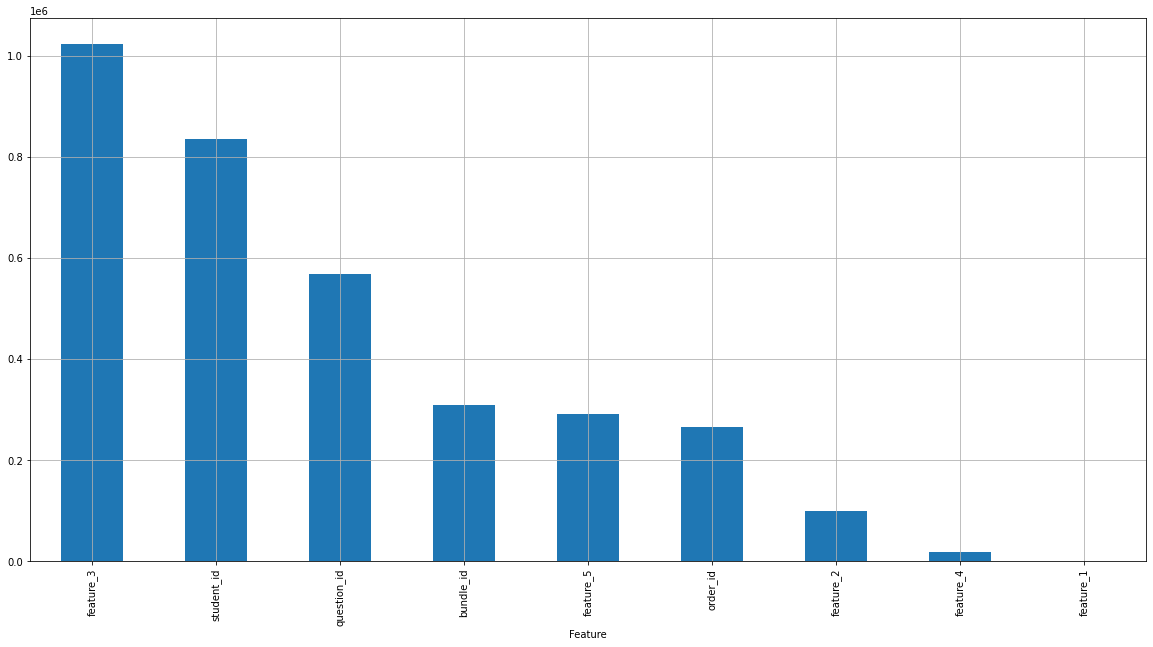

In [ ]:
fast_fi = automl.get_feature_scores('fast', silent = False)
fast_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

# accurate_fi = automl.get_feature_scores('accurate', val, silent = False)
# accurate_fi.set_index('Feature')['Importance'].plot.bar(figsize = (20, 10), grid = True)

In [ ]:
test_pred = automl.predict(val)

print('Prediction for test data:\n{}\nShape = {}'.format(test_pred, test_pred.shape))

print('Check scores...')
print('OOF score: {}'.format(roc_auc_score(train[TARGET_NAME].values, oof_pred.data)))
print('TEST score: {}'.format(roc_auc_score(val[TARGET_NAME].values, test_pred.data)))

Prediction for test data:
array([[4.4309591e-06],
       [9.1617179e-01],
       [7.6041871e-01],
       ...,
       [7.9990435e-01],
       [9.4212717e-01],
       [4.9161494e-01]], dtype=float32)
Shape = (59008, 1)
Check scores...
OOF score: 0.887750357557155
TEST score: 0.8824260260655831
